In [20]:
%pylab nbagg
from tvb.simulator.lab import *
import os.path
from matplotlib import colors, cm
import time
import scipy.signal as sig
import scipy.io as sio
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import h5py
datafile = '/Users/adam2392/Documents/eztrack/python/output/pt1sz2_gamma_svd.hdf'

class Container:
    def __init__(self, data, **kwargs):
        self.data = data
        self.metadata = kwargs

def loadarray(filename):
    with h5py.File(filename, 'r') as infile:
        dataset = infile['data']
        arraydata = dataset[...] # get the numpy array

        metadata = dict()
        for attr in dataset.attrs:
            metadata[attr] = dataset.attrs[attr]
        
        container = Container(arraydata, **metadata)
        
with h5py.File(datafile, 'r') as infile:
    svd = infile['svdu']
    svd = svd[...]
    
    # set attributes
#     dataset.attrs['winsize'] = winsize
#     dataset.attrs['stepsize'] = stepsize
#     dataset.attrs['freqband'] = freqband
#     dataset.attrs['freqrange'] = coherencemodel.freqbands

#     # set metadata
#     metadata.attrs["samplerate"] = patieeg.samplefreq.values
#     metadata.attrs["recordduration"] = patieeg.recordduration.values
#     metadata.attrs['onset_time'] = patieeg.onset_time.values
#     metadata.attrs['offset_time'] = patieeg.offset_time.values
print svd.shape

(267, 86, 86)


In [2]:
nez=1
npz=2

# Patient specific modifications
Gez = [[],[7]]
Gpz = [[13,6,7,11,13,27,34,83],[5,6,7,11,13,27,34,83],[5,6,7,11,13,27,34,83],[5,6,7,11,28,27,34,83]]

In [3]:
ez=Gez[nez]
pz=Gpz[nez][:npz]

In [4]:
nb_regions

NameError: name 'nb_regions' is not defined

In [10]:
project_dir = os.path.join(os.getcwd(), 'data')
timeseries_dir='./Simulated'
additionname='LS_RB'

In [11]:
if not os.path.exists(timeseries_dir):
    os.makedirs(timeseries_dir)

In [12]:
con = connectivity.Connectivity.from_file(os.path.join(project_dir, "connectivity.zip"))
con.speed = np.inf
# normalize
con.weights = con.weights/np.max(con.weights)
nb_regions = len(con.region_labels)

<IPython.core.display.Javascript object>


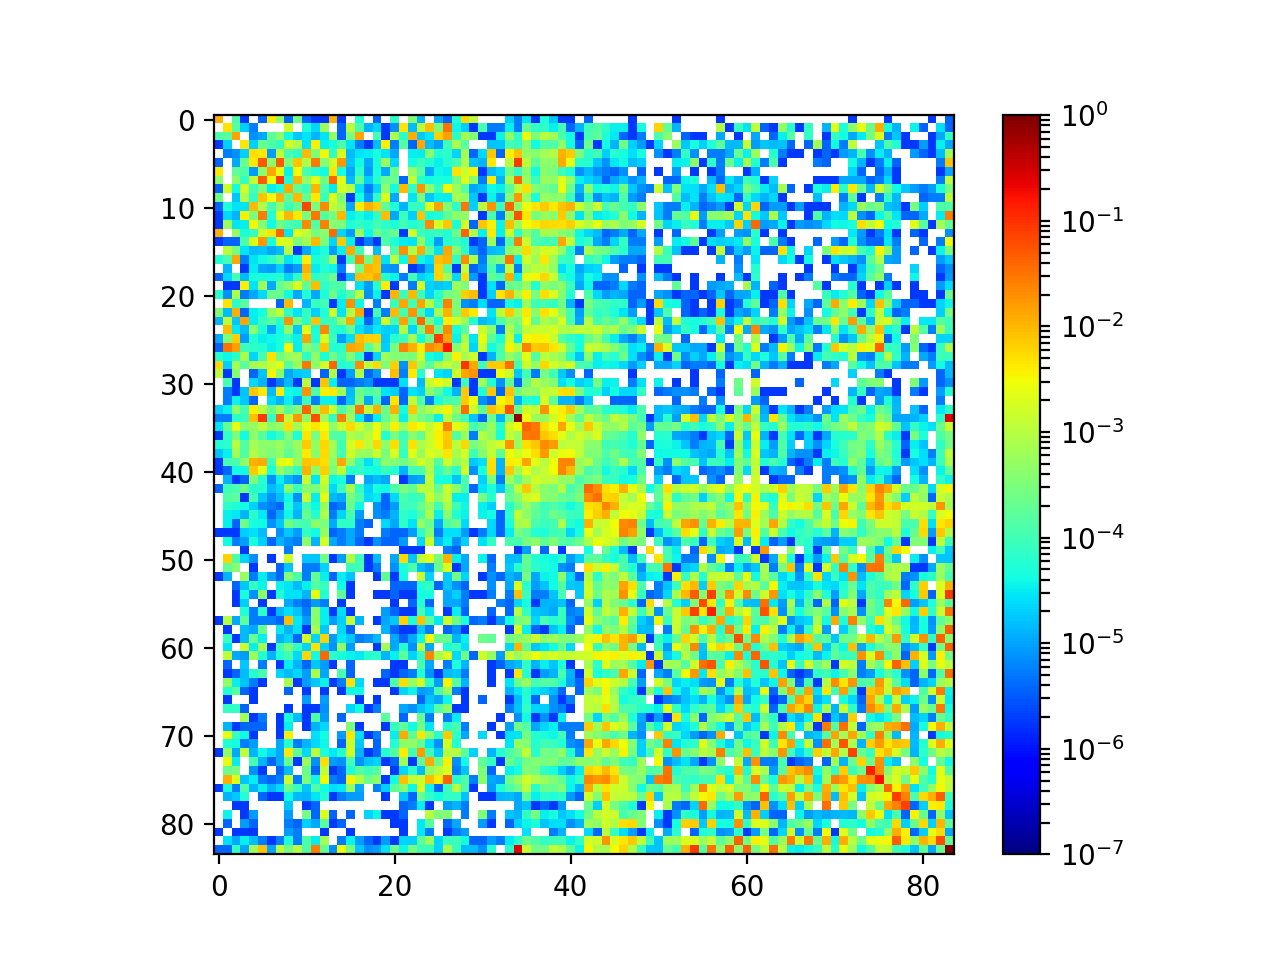

In [13]:
figure()
image = con.weights
norm = colors.LogNorm(1e-7, image.max()) #, clip='True')
imshow(image, norm=norm, cmap=cm.jet)
colorbar()
#max(con.weights[con.weights != 0])

In [14]:
x0ez=-1.6
x0pz=-2.4
x0num=-2.4

In [15]:
coupl = coupling.Difference(a=1.)

#Initialise some Monitors with period in physical time
mon_tavg = monitors.TemporalAverage(period=1.)
 


print nb_regions

# Epileptor model
epileptors = models.Epileptor(Ks=-2, r=0.0002, tau = 10, tt = 0.07)
epileptors.x0 = -2.4*np.ones(nb_regions)
epileptors.x0[ez] = -1.6


epileptors.state_variable_range['x1'] = r_[-0.5, 0.1]
epileptors.state_variable_range['z'] = r_[3.5,3.7]
epileptors.state_variable_range['y1'] = r_[-0.1,1]
epileptors.state_variable_range['x2'] = r_[-2.,0.]
epileptors.state_variable_range['y2'] = r_[0.,2.]
epileptors.state_variable_range['g'] = r_[-1.,1.]


mon_SEEG = monitors.iEEG.from_file(sensors_fname=os.path.join(project_dir, "seeg.txt"),
                                   projection_fname=os.path.join(project_dir, "gain_inv-square.txt"),
                                   rm_f_name=os.path.join(project_dir, "regionMapping_16k_76.txt"),
                                   period=1.0,
                                   variables_of_interest=[0]
                                   )
what_to_watch_average  = [mon_tavg,]

# Integrator
hiss = noise.Additive(nsig = numpy.array([0.001, 0.001, 0., 0.0001, 0.0001, 0.]))
heunint_n = integrators.HeunStochastic(dt=0.05, noise=hiss)

#Initialise a Simulator -- Model, Connectivity, Integrator, and Monitors.
sim = simulator.Simulator(model=epileptors, 
                          connectivity=con, 
                          coupling=coupl, 
                          integrator=heunint_n, 
                          monitors=what_to_watch_average)
######It's necessary to run this before sim.run()
sim.configure()  # configure a Simulator


(ttavg, tavg), = sim.run(simulation_length= 50000)

# Normalize the time series to have nice plots
#tavg /= (np.max(tavg,0) - np.min(tavg,0 ))

84


In [16]:
tavg /= (np.max(tavg,0) - np.min(tavg,0 ))

In [17]:
np.shape(tavg)

(50000, 2, 84, 1)

In [18]:
epileptors.variables_of_interest

array(['x2 - x1', 'z'],
      dtype='|S7')

In [19]:
mon_tavg = monitors.TemporalAverage(period=1.0)

num_contacts = mon_SEEG.sensors.labels.size

con.cortical[:] = True     # To avoid adding analytical gain matrix for subcortical sources

sim = simulator.Simulator(model=epileptors,
                          connectivity=con,
                          coupling=coupl,
                          conduction_speed=np.inf,                          
                          integrator=heunint,
                          monitors=[mon_tavg, mon_SEEG])

sim.configure()

(ttavg, tavg), (tseeg, seeg) = sim.run(simulation_length=10000)

# Normalize the time series to have nice plots
tavgn = tavg/(np.max(tavg, 0) - np.min(tavg, 0))
seegn = seeg/(np.max(seeg, 0) - np.min(seeg, 0))
seegn = seegn - np.mean(seegn, 0)

b, a = sig.butter(2, 0.1, btype='highpass', output='ba')
#seegf = sig.filtfilt(B, A, seegn)
seegf = np.zeros(seegn.shape)
for i in range(num_contacts):
    seegf[:, 0, i, 0] = sig.filtfilt(b, a, seeg[:, 0, i, 0])

NameError: name 'heunint' is not defined

In [ ]:
print seeg.shape
print tavg.shape

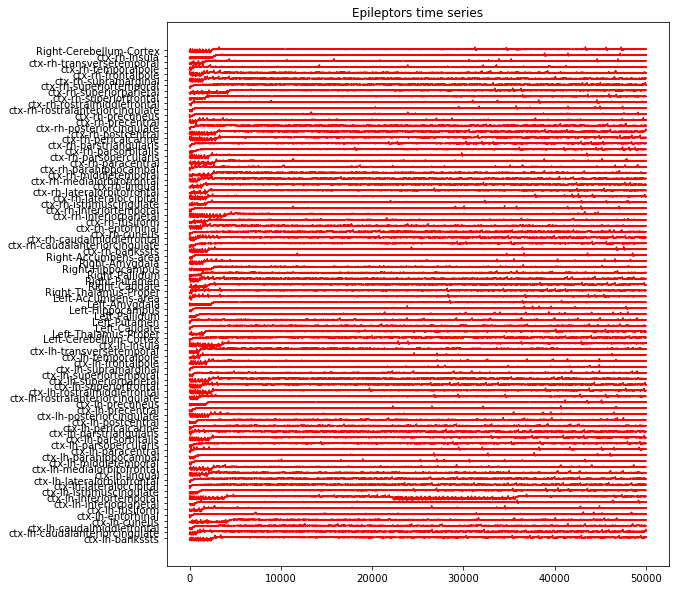

In [40]:
#Plot raw time series
figure(figsize=(9,10))

indf = 0
indt = -1

regf = 0
regt = 84

plot(ttavg[indf:indt], tavg[indf:indt, 0, regf:regt, 0] + np.r_[regf:regt], 'r')
yticks(np.r_[regf:regt], con.region_labels[regf:regt])
title("Epileptors time series")
#tight_layout()
#savefig(os.path.join(timeseries_dir, 'NodetimeSeries_Nez_'+str(nez)+'_Npz_'+str(npz)+'.png'))

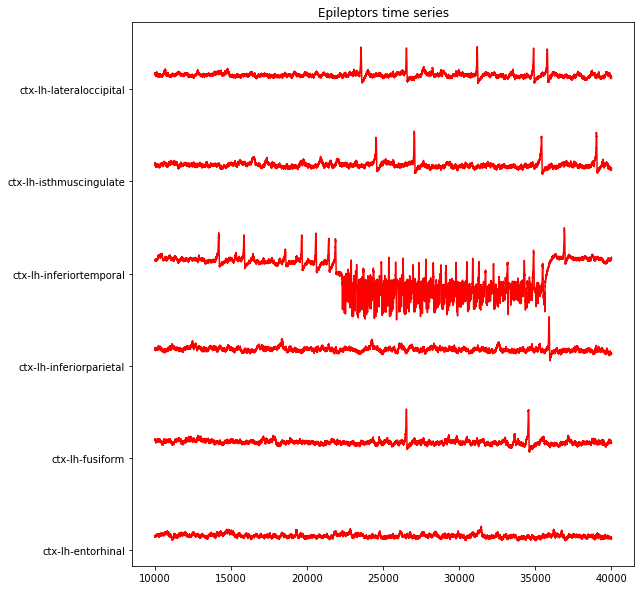

In [41]:
figure(figsize=(9,10))

indf = 10000
indt = 40000

regf = 4
regt = 10

plot(ttavg[indf:indt], tavg[indf:indt, 0, regf:regt, 0] + np.r_[regf:regt], 'r')
yticks(np.r_[regf:regt], con.region_labels[regf:regt])
title("Epileptors time series")

In [42]:
np.shape(tavg)

(50000, 2, 84, 1)

In [43]:
sensor = sensors.SensorsInternal.from_file(source_file=os.path.join(project_dir, "seeg.txt"))
contacts = sensor.labels
seeg_xyz =  sensor.locations

print contacts.shape
print seeg_xyz.shape

nsens = seeg_xyz.shape[0]



def simplest_gain_matrix(seeg_xyz, reg_xyz= np.ndarray):
    
    #reg_xyz = con.centres
    dr = reg_xyz - seeg_xyz[:, newaxis]
    ndr = sqrt((dr**2).sum(axis=-1))
    Vr = 1.0 / (4 * pi) / ndr**2
    return Vr


simplest_gain = simplest_gain_matrix(seeg_xyz, reg_xyz = con.centres)
simplest_gain.shape



new = tavg[:,0,:,0].T


(165,)
(165, 3)


In [44]:
seeg = np.dot(simplest_gain, new)

In [45]:
np.shape(seeg)

(165, 50000)

In [46]:
seeg /= (np.max(seeg,0) - np.min(seeg,0 ))

In [47]:
seeg[1,1:2000]

array([-0.0482983 , -0.05022729, -0.0506129 , ..., -0.04171915,
       -0.04489161, -0.04464201])

In [81]:
num_contacts,timepoint=np.shape(prod_simpl)

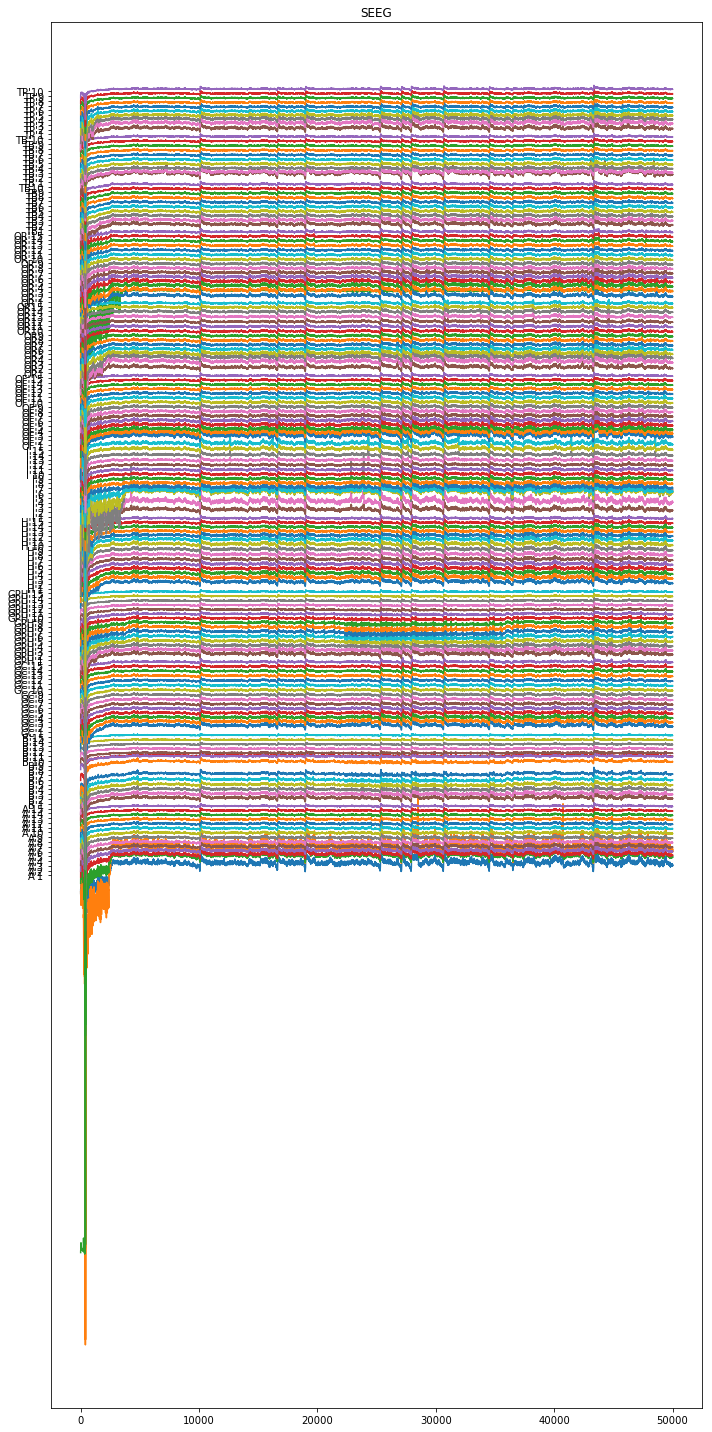

In [48]:
figure(figsize=(10,20))
plot(ttavg[:], seeg[:].T*100 + np.r_[:num_contacts])
yticks(np.r_[:num_contacts], mon_SEEG.sensors.labels[:])
title("SEEG")
tight_layout()
savefig(os.path.join(timeseries_dir, 'SeegtimeSeries_Nez_'+str(nez)+'_Npz_'+str(npz)+'.png'))

In [61]:
np.r_[:fcontacts-scontacts-1]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18])

In [71]:
intf=6000
ints=50000

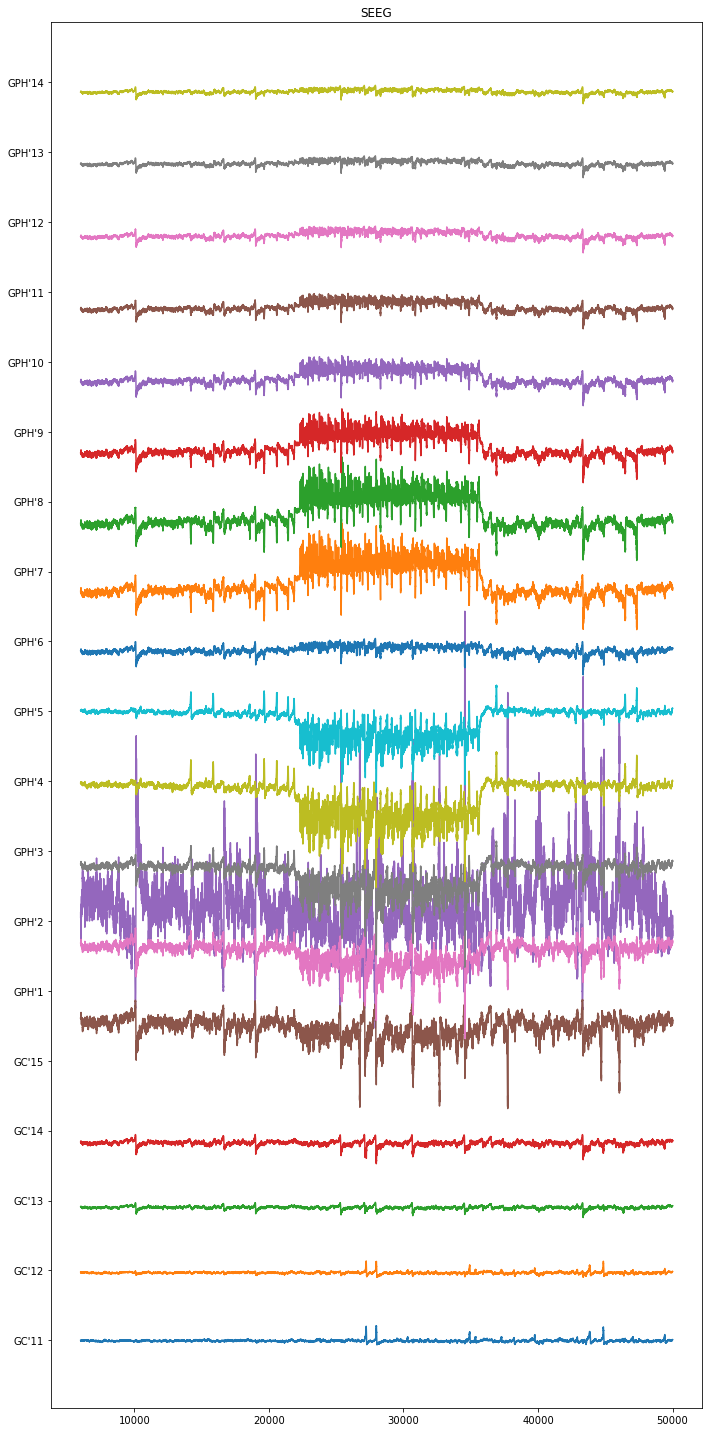

In [72]:
num_contacts=20
scontacts=40
fcontacts=60
bipseeg=seeg[scontacts+1:fcontacts] - seeg[scontacts:fcontacts-1]
bipseeg /= (np.max(bipseeg) - np.min(bipseeg))

figure(figsize=(10,20))
plot(ttavg[intf:ints], bipseeg.T[intf:ints]*100+ np.r_[:fcontacts-scontacts-1])
yticks(np.r_[:fcontacts-scontacts-1], mon_SEEG.sensors.labels[scontacts:fcontacts-1])
title("SEEG")
tight_layout()
savefig(os.path.join(timeseries_dir, 'bipSeegtimeSeries_Nez_'+str(nez)+'_Npz_'+str(npz)+'.png'))

In [76]:
save(os.path.join(timeseries_dir, additionname+'Nez_'+str(nez)+'_Npz_'+str(npz)+'.npy'), seeg)

In [83]:
a_dict={'tsSEEG':seeg,
       'tpNodes':ttavg,
        'tsNodes':tavg,
        'x0':{'x0ez':x0ez,'x0pz':x0pz,'x0num':x0num},
        'ez':con.region_labels[ez],
        'pz':con.region_labels[pz],
       }

sio.savemat(os.path.join(timeseries_dir, 'timeSeries_Nez_'+str(nez)+'_Npz_'+str(npz)+'.mat'),{'Data':a_dict})